# **Importing Necessary Libraries**

In [15]:
import numpy as np
import torch
import os
import random
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import torch.nn as nn
import torch.optim as optim
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset Path**

In [16]:
dataset_dir = '/content/drive/MyDrive/X-Ray/X-Ray'

In [17]:
import os

# Print files in the carious and non_carious folders
carious_files = os.listdir(os.path.join(dataset_dir, 'carious'))
non_carious_files = os.listdir(os.path.join(dataset_dir, 'non_carious'))

print("Files in 'carious' folder:", carious_files)
print("Files in 'non_carious' folder:", non_carious_files)


Files in 'carious' folder: ['6r (111).jpg', '6r (12).png', '6r (135).jpg', '6r (138).jpg', '6r (130).jpg', '6r (136).jpg', '6r (1).jpg', '6r (106).jpg', '6r (10).png', '6r (108).jpg', '6r (13).png', '6r (125).jpg', '6r (10).jpg', '6r (137).jpg', '6r (113).jpg', '6r (105).jpg', '6r (133).jpg', '6r (112).jpg', '6r (114).jpg', '6r (11).jpg', '6r (100).jpg', '6r (118).jpg', '6r (132).jpg', '6r (103).jpg', '6r (128).jpg', '6r (122).jpg', '6r (12).jpg', '6r (116).jpg', '6r (119).jpg', '6r (127).jpg', '6r (129).jpg', '6r (120).jpg', '6r (131).jpg', '6r (126).jpg', '6r (1).png', '6r (104).jpg', '6r (121).jpg', '6r (101).jpg', '6r (117).jpg', '6r (107).jpg', '6r (110).jpg', '6r (13).jpg', '6r (123).jpg', '6r (102).jpg', '6r (134).jpg', '6r (115).jpg', '6r (11).png', '6r (109).jpg', '6r (124).jpg', '6r (139).jpg', '6r (183).jpg', '6r (14).png', '6r (15).jpg', '6r (142).jpg', '6r (185).jpg', '6r (184).jpg', '6r (16).png', '6r (188).jpg', '6r (18).png', '6r (17).jpg', '6r (15).png', '6r (146).jpg'

# **Image Data Loading**

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the dataset from the main directory (after cleaning)
dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)

# Define train, validation, and test split sizes
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # Remaining 15% for testing

# Split the dataset
train_subset, valid_subset, test_subset = random_split(dataset, [train_size, valid_size, test_size])

# Apply transformations to the respective subsets
train_subset.dataset.transform = train_transform
valid_subset.dataset.transform = test_transform
test_subset.dataset.transform = test_transform

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Print class names
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['carious', 'non_carious']


# **Counting Images**

In [20]:
from __future__ import print_function
from collections import Counter

# Get class names and their indices from the entire dataset
class_names = dataset.classes  # Class names (e.g., ['carious', 'non-carious'])
class_to_idx = dataset.class_to_idx  # Mapping of class names to indices
print("Class Names and Indices:", class_to_idx)

# Function to count images in each class for a given subset
def count_classes(subset, class_names):
    class_counts = Counter()
    for _, label in subset:
        class_counts[class_names[label]] += 1
    return class_counts

# Count images in each class for training, validation, and testing subsets
train_class_counts = count_classes(train_subset, class_names)
valid_class_counts = count_classes(valid_subset, class_names)
test_class_counts = count_classes(test_subset, class_names)

# Display class distributions
print("Class Distribution:")
print("Training:")
for class_name, count in train_class_counts.items():
    print(f" - {class_name}: {count} images")

print("--------------------------")

print("Validation:")
for class_name, count in valid_class_counts.items():
    print(f" - {class_name}: {count} images")

print("--------------------------")

print("Testing:")
for class_name, count in test_class_counts.items():
    print(f" - {class_name}: {count} images")

print("--------------------------")

# Check overall dataset size for each subset
print(f"Total Images in Training Subset: {len(train_subset)}")
print(f"Total Images in Validation Subset: {len(valid_subset)}")
print(f"Total Images in Testing Subset: {len(test_subset)}")


Class Names and Indices: {'carious': 0, 'non_carious': 1}
Class Distribution:
Training:
 - carious: 226 images
 - non_carious: 40 images
--------------------------
Validation:
 - carious: 44 images
 - non_carious: 13 images
--------------------------
Testing:
 - carious: 48 images
 - non_carious: 9 images
--------------------------
Total Images in Training Subset: 266
Total Images in Validation Subset: 57
Total Images in Testing Subset: 57


# **Shape of the Images**

In [32]:
import cv2
import os
import glob

# Function to resize images to a target size
def resize_images_in_folder(input_folder, output_folder, target_size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_path in glob.iglob(os.path.join(input_folder, '*.*')):  # Handles multiple file types
        img = cv2.imread(img_path)

        if img is not None:
            resized_img = cv2.resize(img, target_size)  # Resize to target size
            filename = os.path.basename(img_path)
            output_path = os.path.join(output_folder, filename)

            # Save the resized image and check if it was successful
            if cv2.imwrite(output_path, resized_img):
                print(f"Resized and saved: {filename}")
            else:
                print(f"Failed to save: {filename}")
        else:
            print(f"Could not read: {img_path}")

# Function to process all classes in a dataset directory
def process_dataset_folders(dataset_dir, output_dir, target_size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_folder in os.listdir(dataset_dir):
        input_folder = os.path.join(dataset_dir, class_folder)
        output_folder = os.path.join(output_dir, class_folder)
        if os.path.isdir(input_folder):  # Ensure it's a directory
            print(f"Processing class: {class_folder}")
            resize_images_in_folder(input_folder, output_folder, target_size)

# Assuming dataset_dir is already set to the dataset root folder path
dataset_dir = '/content/drive/MyDrive/Dental X-ray'  # Example dataset root

# Process training, validation, and testing datasets
process_dataset_folders(os.path.join(dataset_dir, "Training"), os.path.join(dataset_dir, "Training"))
process_dataset_folders(os.path.join(dataset_dir, "Validation"), os.path.join(dataset_dir, "Validation"))
process_dataset_folders(os.path.join(dataset_dir, "Testing"), os.path.join(dataset_dir, "Testing"))


Processing class: non_carious
Resized and saved: 6r (176).jpg
Resized and saved: 6r (173).jpg
Resized and saved: 6r (177).jpg
Resized and saved: 6r (174).jpg
Resized and saved: 6r (175).jpg
Resized and saved: 6r (154).jpg
Resized and saved: 6r (148).jpg
Resized and saved: 6r (157).jpg
Resized and saved: 6r (150).jpg
Resized and saved: 6r (144).jpg
Resized and saved: 6r (170).jpg
Resized and saved: 6r (149).jpg
Resized and saved: 6r (172).jpg
Resized and saved: 6r (171).jpg
Resized and saved: 6r (143).jpg
Resized and saved: 6r (168).jpg
Resized and saved: 6r (152).jpg
Resized and saved: 6r (156).jpg
Resized and saved: 6r (155).jpg
Resized and saved: 6r (153).jpg
Resized and saved: 6r (151).jpg
Resized and saved: 6r (167).jpg
Resized and saved: 6r (169).jpg
Resized and saved: 6r (166).jpg
Resized and saved: 6r (164).jpg
Resized and saved: 6r (165).jpg
Resized and saved: 6r (163).jpg
Resized and saved: 6r (161).jpg
Resized and saved: 6r (162).jpg
Resized and saved: 6r (160).jpg
Resized an

In [33]:
for images, labels in train_loader:
    for i in range(len(images)):
        img = images[i]  # Access the i-th image from the batch
        width, height = img.shape[1], img.shape[2]  # Get image dimensions (width, height)

        # Get class name by mapping the label to the class names
        class_name = dataset.classes[labels[i]]

        print(f"Class: {class_name:<20} | Shape: {width:>4}x{height:>4}")


Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: cariou

In [34]:
for images, labels in valid_loader:
    for i in range(len(images)):
        img = images[i]  # Access the i-th image from the batch
        width, height = img.shape[1], img.shape[2]  # Get image dimensions (width, height)

        # Get class name by mapping the label to the class names
        class_name = dataset.classes[labels[i]]

        print(f"Class: {class_name:<20} | Shape: {width:>4}x{height:>4}")


Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: cariou

In [35]:
for images, labels in test_loader:
    for i in range(len(images)):
        img = images[i]  # Access the i-th image from the batch
        width, height = img.shape[1], img.shape[2]  # Get image dimensions (width, height)

        # Get class name by mapping the label to the class names
        class_name = dataset.classes[labels[i]]

        print(f"Class: {class_name:<20} | Shape: {width:>4}x{height:>4}")


Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: non_carious          | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: carious              | Shape:  224x 224
Class: cariou

# **Visualize a Random Image**

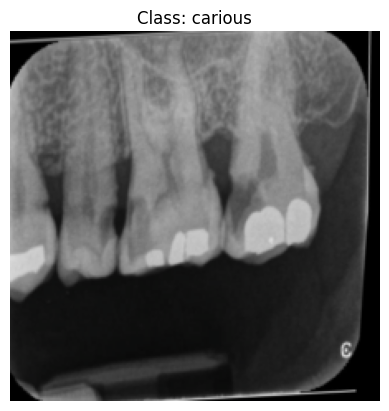

In [42]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# Function to visualize a random image from the dataset
def visualize_random_image(dataset, class_names):
    # Randomly pick an image from the dataset
    random_index = random.randint(0, len(dataset) - 1)
    random_image, label = dataset[random_index]  # This returns a tuple (image, label)

    # Convert the tensor back to numpy array for imshow (H, W, C)
    random_image = random_image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

    # Denormalize the image (if necessary)
    mean = np.array([0.485, 0.456, 0.406])  # Example mean values used in normalization
    std = np.array([0.229, 0.224, 0.225])   # Example std values used in normalization
    random_image = random_image * std + mean  # Undo normalization
    random_image = np.clip(random_image, 0, 1)  # Ensure values are in [0, 1] range

    # Display the image
    plt.imshow(random_image)
    plt.title(f"Class: {class_names[label]}")  # Display class name as title
    plt.axis('off')  # Hide axis
    plt.show()


# Get the class names from the dataset
#class_names = dataset_dir.classes

# Call the function to visualize a random image from the training dataset
visualize_random_image(dataset, class_names)


# **Train the Model**

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layers
        # After 3 pooling layers (each with kernel_size=2), the size is reduced from 224x224 to 28x28
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust the input size after pooling
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes (carious, non-carious)

    def forward(self, x):
        # Convolutional layers with ReLU activations and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Pooling layer (size 2x2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        # Flatten the output of the convolutional layers
        x = torch.flatten(x, 1)  # Flatten to a vector for the fully connected layer

        # Fully connected layers
        x = F.relu(self.fc1(x))
        features = x  # Features before the final output layer

        # Final output layer for classification (carious vs. non-carious)
        x = self.fc2(x)

        return features, x  # Return both features and predictions


In [46]:
def calculate_accuracy(model, valid_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Turn off gradients for validation
        for images, labels in valid_loader:
            # Forward pass: Get predictions
            _, outputs = model(images)

            # Get the predicted class (the index with the highest output value)
            _, predicted = torch.max(outputs, 1)

            # Calculate the number of correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100  # Calculate accuracy percentage
    return accuracy


In [49]:
# Initialize the model, loss function, and optimizer
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        features, outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Calculate accuracy on the validation set after each epoch
    accuracy = calculate_accuracy(model, valid_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {accuracy:.2f}%")


Epoch 1/10, Loss: 1.4129, Validation Accuracy: 77.19%
Epoch 2/10, Loss: 0.4472, Validation Accuracy: 77.19%
Epoch 3/10, Loss: 0.3473, Validation Accuracy: 84.21%
Epoch 4/10, Loss: 0.2206, Validation Accuracy: 84.21%
Epoch 5/10, Loss: 0.3246, Validation Accuracy: 96.49%
Epoch 6/10, Loss: 0.2021, Validation Accuracy: 85.96%
Epoch 7/10, Loss: 0.1350, Validation Accuracy: 91.23%
Epoch 8/10, Loss: 0.1106, Validation Accuracy: 98.25%
Epoch 9/10, Loss: 0.0677, Validation Accuracy: 94.74%
Epoch 10/10, Loss: 0.0672, Validation Accuracy: 98.25%


# **Evaluation on Test set Accuracy**

In [50]:
test_accuracy = calculate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.25%


## **Confusion Marix**

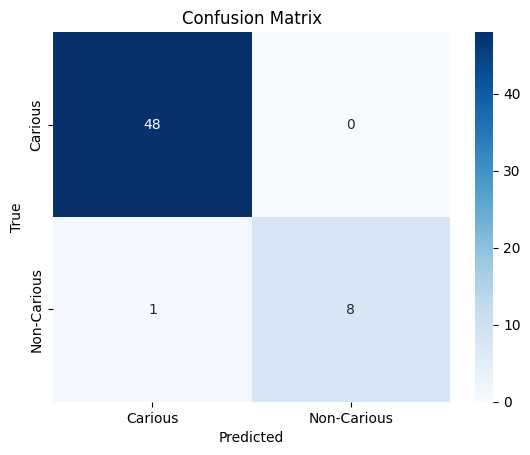

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, test_loader, device, class_labels):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available
            _, outputs = model(inputs)  # Get model outputs
            _, predicted = torch.max(outputs, 1)  # Get the class predictions (max score)

            all_labels.extend(labels.cpu().numpy())  # Convert labels to CPU and append
            all_preds.extend(predicted.cpu().numpy())  # Convert predictions to CPU and append

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define your class labels
class_labels = ["Carious", "Non-Carious"]  # Adjust based on your dataset's classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the correct device

# Assuming you have already defined the `test_loader` and `model` before
# Example:
plot_confusion_matrix(model, test_loader, device, class_labels)


# **Prediction on Random image**

Saving WhatsApp Image 2024-12-23 at 8.07.56 PM.jpeg to WhatsApp Image 2024-12-23 at 8.07.56 PM.jpeg


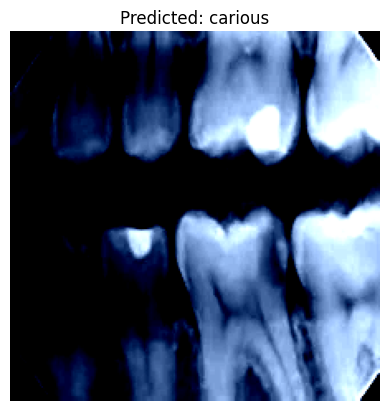

Predicted: carious


In [61]:
import cv2
import torch
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Upload an image
uploaded = files.upload()
image_path = next(iter(uploaded.keys()))

# Load and preprocess the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to match model input size

# Normalize the image (match training normalization)
mean = np.array([0.485, 0.456, 0.406])  # Mean used for normalization in training
std = np.array([0.229, 0.224, 0.225])   # Std used for normalization in training
img = img.astype('float32') / 255.0  # Normalize to [0, 1] range
img = (img - mean) / std  # Normalize to the same distribution as training data

# Convert to tensor and add batch dimension
img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()  # Ensure the tensor is float32

# Ensure the model is on the same device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Move model to appropriate device
img_tensor = img_tensor.to(device)  # Move image tensor to appropriate device

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output[1], 1)  # We use the second output (predictions)

# Class labels (make sure they are in the correct order)
class_labels = ["carious", "non_carious"]

# Plot the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_labels[predicted.item()]}")
plt.show()

# Print the prediction class label
print(f"Predicted: {class_labels[predicted.item()]}")


# **Show Predicted Images**

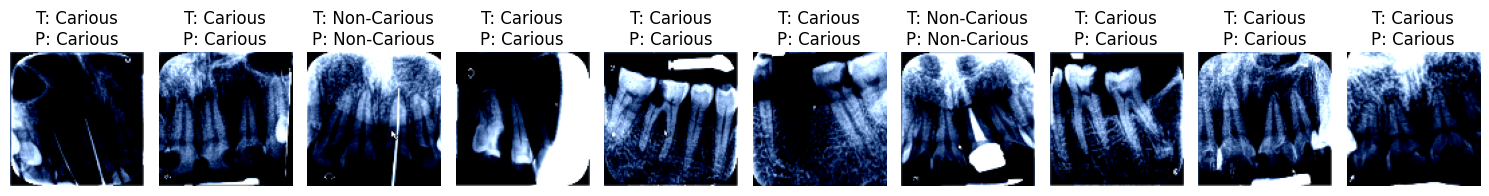

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

# Define class labels
class_labels = ["Carious", "Non-Carious"]

# Function to visualize predictions with smaller images
def visualize_predictions(model, test_loader, class_labels, num_images=10, image_size=(100, 100)):
    model.eval()
    images_shown = 0  # Counter for displayed images
    all_images = []

    with torch.no_grad():
        # Gather all images and predictions
        for images, labels in test_loader:
            # Get the model outputs (make sure the output is from the final classification layer)
            features, outputs = model(images)  # Unpack the features and predictions

            _, predicted = torch.max(outputs, 1)  # Get the predicted class labels

            # Store images, true labels, and predicted labels
            for i in range(len(images)):
                img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
                img = np.clip(img * 255, 0, 255).astype(np.uint8)  # Convert to uint8
                all_images.append((img, labels[i].item(), predicted[i].item()))

            if len(all_images) >= num_images:  # Break when enough images are gathered
                break

    # Randomly select `num_images` from the collected data
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Display the images in a single horizontal axis
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, (img, true_label, pred_label) in enumerate(selected_images):
        # Resize the images to the smaller size
        img_resized = cv2.resize(img, image_size)  # Resize to the specified smaller size
        axs[idx].imshow(img_resized)
        axs[idx].axis("off")
        axs[idx].set_title(f"T: {class_labels[true_label]}\nP: {class_labels[pred_label]}")
    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
visualize_predictions(model, test_loader, class_labels)
